In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import time
from keras import layers
from keras import models
from keras import optimizers
from keras import callbacks
from keras import backend as K
from sklearn import model_selection
from sklearn import preprocessing
import pathlib

Using TensorFlow backend.


In [2]:
COORDINATES = ["Xmin", "Ymin", "Xmax", "Ymax"]

In [3]:
answers = pd.read_csv("../raw/train_answers.csv").set_index("itemId")
answers.columns = COORDINATES
scaler = preprocessing.StandardScaler().fit(np.vstack([answers.values, answers.values[:, [2, 3, 0, 1]]]))
answers[COORDINATES] = scaler.transform(answers[COORDINATES])

/Users/WLMike/Documents/PycharmProjects/ML_venv/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/WLMike/Documents/PycharmProjects/ML_venv/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


In [4]:
votes = pd.read_csv("../raw/train_data.csv").set_index("itemId")
votes[COORDINATES] = scaler.transform(votes[COORDINATES])

/Users/WLMike/Documents/PycharmProjects/ML_venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  


In [5]:
votes_test = pd.read_csv("../raw/test_data.csv").set_index("itemId")
votes_test[COORDINATES] = scaler.transform(votes_test[COORDINATES])

/Users/WLMike/Documents/PycharmProjects/ML_venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  


In [6]:
def yield_batch(data):
    votes, answers = data
    item_ids = list(set(votes.index))
    while True:
        item_id = np.random.choice(item_ids, 1)
        forecasts = votes.loc[item_id].set_index("userId")
        x = np.zeros((1, len(forecasts), 4),)
        y = np.zeros((1, 4))
        x[0] = forecasts.sample(len(forecasts))
        y[0] = answers.loc[item_id]
        yield x, y

In [7]:
def yield_batch_val(data):
    votes, answers = data
    item_ids = set(votes.index)
    while True:
        for item_id in item_ids:
            forecasts = votes.loc[item_id].set_index("userId")
            x = np.zeros((1, len(forecasts), 4),)
            y = np.zeros((1, 4))

            x[0] = forecasts
            y[0] = answers.loc[item_id]
            yield x, y

In [8]:
def yield_batch_test(data):
    item_ids = data.index.unique()
    for item_id in item_ids:
        forecasts = data.loc[item_id].set_index("userId")
        x = np.zeros((1, len(forecasts), 4),)
        y = np.zeros((1, 4))
        x[0] = forecasts
        yield x

In [9]:
def intersection_over_union(boxes_pred, boxes_true):

    x_min = K.stack([boxes_pred[:, 0], boxes_true[:, 0]], axis=-1)
    y_min = K.stack([boxes_pred[:, 1], boxes_true[:, 1]], axis=-1)
    x_max = K.stack([boxes_pred[:, 2], boxes_true[:, 2]], axis=-1)
    y_max = K.stack([boxes_pred[:, 3], boxes_true[:, 3]], axis=-1)

    x_min = K.max(x_min, axis=-1)
    y_min = K.max(y_min, axis=-1)
    x_max = K.min(x_max, axis=-1)
    y_max = K.min(y_max, axis=-1)

    zeros = K.zeros_like(x_max)

    x_inter = K.stack([zeros, x_max - x_min], axis=-1)
    y_inter = K.stack([zeros, y_max - y_min], axis=-1)

    x_inter = K.max(x_inter, axis=-1)
    y_inter = K.max(y_inter, axis=-1)
    inter_area = x_inter * y_inter
    
    area_pred = (K.max(K.stack([zeros, boxes_pred[:, 2] - boxes_pred[:, 0]], axis=-1), axis=-1) * 
                 K.max(K.stack([zeros, boxes_pred[:, 3] - boxes_pred[:, 1]], axis=-1), axis=-1))
    area_true = (K.max(K.stack([zeros, boxes_true[:, 2] - boxes_true[:, 0]], axis=-1), axis=-1) * 
                 K.max(K.stack([zeros, boxes_true[:, 3] - boxes_true[:, 1]], axis=-1), axis=-1))

    iou = inter_area / (area_pred + area_true - inter_area + K.epsilon())
    
    return -K.mean(iou, axis=-1)

In [11]:
def make_model(filters):
    K.clear_session()
    
    y = x = layers.Input(shape=(None, 4))
    
    mul = 4
    for i in range(6):
        y = layers.Conv1D(
            filters=filters * 4,
            kernel_size=3,
            strides=1,
            padding="same",
            activation="relu"
        )(y)
        
    y = layers.GlobalAveragePooling1D()(y)
    
    y = layers.Dense(
        units=filters * 2,
        activation="relu"
    )(y)
    y = layers.Dense(
        units=4,
        activation=None
    )(y)
    
    model = models.Model(inputs=x, outputs=y)
    model.summary()
    return model

In [12]:
class MaxLRTest(callbacks.Callback):

    def __init__(self, base_lr=1.0e-9, max_lr=10, steps=10000):
        super().__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.steps = steps
        
        self.iterations = None
        self.history = None
        
    def clr(self):
        return self.base_lr * (self.max_lr / self.base_lr) ** (self.iterations / self.steps) 
  
    def on_train_begin(self, logs=None):
        self.iterations = 0
        self.history = {}
        K.set_value(self.model.optimizer.lr, self.base_lr)     
            
    def on_batch_end(self, batch, logs=None):
        if self.iterations > self.steps:
            self.model.stop_training = True
        
        self.history.setdefault("iterations", []).append(self.iterations)
        self.history.setdefault("lr", []).append(K.get_value(self.model.optimizer.lr))
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
            
        self.iterations += 1
        K.set_value(self.model.optimizer.lr, self.clr())
        
    def plot(self, smooth=None, t_score=2):
        smooth = int(smooth or self.steps // 10)
        df = pd.DataFrame(self.history).set_index("lr").loss.rolling(smooth).agg(["mean", "std"])
        df["std"] = df["mean"] + t_score * df["std"] / smooth ** 0.5
        print(f"Max speed learning rate  - {df['std'].idxmin():.1e}")
        df.plot(logx=True, figsize=(16, 8))

In [13]:
class DecayingLR(callbacks.Callback):

    def __init__(self, max_lr=0.1, warm_up=1, decay_per_epoch=1, epsilon=0.0001, wait=3):
        super().__init__()

        self.max_lr = max_lr
        self.warm_up = warm_up
        self.decay_per_epoch = decay_per_epoch
        self.epsilon=epsilon
        self.wait=wait
        
        self.iterations = None
        self.history = None
        
        self.d_loss_iterations = None
        self.d_loss = None
        self.d_iterations = None
        self.d_iterations2 = None
        self.d_1 = None
                
        self.steps = None
        self.decay = None
        
        self.wait_count=None
        self.prev_loss=None

    def on_train_begin(self, logs=None):
        self.iterations = 1
        self.history = {}
        
        self.d_loss_iterations = 0.0
        self.d_loss = 0.0
        self.d_iterations = 0.0
        self.d_iterations2 = 0.0
        self.d_1 = 0.0
        
        self.steps = self.params["steps"]
        self.decay = (1 - 1 / self.steps) ** (1 / self.decay_per_epoch)
        
        self.wait_count=0
        self.prev_loss=None
        
        K.set_value(self.model.optimizer.lr, self.lr())
    
    def make_decay(self, old, new):
        decay = self.decay
        return old * decay + new * (1 - decay)
    
    def lr(self):
        warm_up = self.iterations / self.steps * self.warm_up
        if warm_up <= 1:
            return self.max_lr * warm_up 
        
        lr = self.history["lr"][-1]
        speed = self.history["speed"][-1]
        
        if speed > 0:
            return lr * self.decay
        
        return lr
            
    def on_batch_end(self, batch, logs=None):
        self.history.setdefault("iterations", []).append(self.iterations)
        self.history.setdefault("lr", []).append(K.get_value(self.model.optimizer.lr))
        
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
            
        self.d_loss_iterations = self.make_decay(self.d_loss_iterations, logs["loss"] * self.iterations)
        self.d_loss = self.make_decay(self.d_loss, logs["loss"])
        self.d_iterations = self.make_decay(self.d_iterations, self.iterations)
        self.d_iterations2 = self.make_decay(self.d_iterations2, self.iterations ** 2)
        self.d_1 = self.make_decay(self.d_1, 1)
        
        cov = self.d_loss_iterations - self.d_loss * self.d_iterations / self.d_1
        var = self.d_iterations2 - self.d_iterations ** 2 / self.d_1
        
        speed = self.steps * cov / var
        self.history.setdefault("speed", []).append(speed)
        
        self.iterations += 1
        K.set_value(self.model.optimizer.lr, self.lr())     
        
    def on_epoch_end(self, epoch, logs=None):
        lr = self.history["lr"][-1]
        speed = self.history["speed"][-1]
        print(f"Learning rate: {lr:.1e}")
        print(f"Speed per epoch: {speed:.4f}")
        
        if self.prev_loss is None:
            self.prev_loss = logs["val_loss"]
        elif abs(self.prev_loss - logs["val_loss"]) < self.epsilon:
            self.wait_count += 1
        else:
            self.wait_count = 0
        self.prev_loss = logs["val_loss"]
        print(f"Wait to stop: {self.wait - self.wait_count}\n")
        if self.wait == self.wait_count:
            self.model.stop_training = True
        
    def plot(self, smooth=None):
        smooth = int(smooth or self.steps)
        df = pd.DataFrame(self.history).set_index("iterations")[["loss", "lr"]].rolling(smooth).mean()
        df.plot(figsize=(16, 8), secondary_y="lr")

In [24]:
def train_model(data_train, data_val, units, test=False):
    
    max_lr =  9.9e-04
    
    steps = 100000
    steps_per_epoch = 1000
    epochs = steps // steps_per_epoch
    
    model = make_model(units)  
    
    model.compile(optimizer=optimizers.Nadam(lr=max_lr / 100, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004),
                      loss="mae",
                      metrics=[intersection_over_union]
        )
    rez = model.fit_generator(
            yield_batch(data_train),
            steps_per_epoch=1000,
            epochs=1,
            callbacks=None,
            validation_data=yield_batch_val(data_val),
            validation_steps=len(data_val[1].index),
        )
    
    
    model.compile(optimizer=optimizers.Nadam(lr=max_lr, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004),
                  loss=intersection_over_union,
                  metrics=None
    )
    cycle = MaxLRTest() if test else DecayingLR(max_lr=max_lr)
    cb = [
        callbacks.ModelCheckpoint("../processed/model.h5", monitor="val_loss", verbose=1, save_best_only=True),
        cycle
    ]
    rez = model.fit_generator(
        yield_batch(data_train),
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        callbacks=cb,
        validation_data=yield_batch_val(data_val),
        validation_steps=len(data_val[1].index),
        )
    
    model = models.load_model("../processed/model.h5", custom_objects={"intersection_over_union": intersection_over_union})
    
    return rez, cycle, model

In [22]:
train_model((votes, answers), (votes, answers), 16, True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, 4)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 64)          832       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 64)          12352     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 64)          12352     
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 64)          12352     
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 64)          12352     
_________________________________________________________________
conv1d_6 (Conv1D)            (None, None, 64)          12352     
__________

(<keras.callbacks.History at 0x7fa000db43c8>,
 <keras.engine.training.Model at 0x7fa03249acf8>)

Max speed learning rate  - 9.9e-04


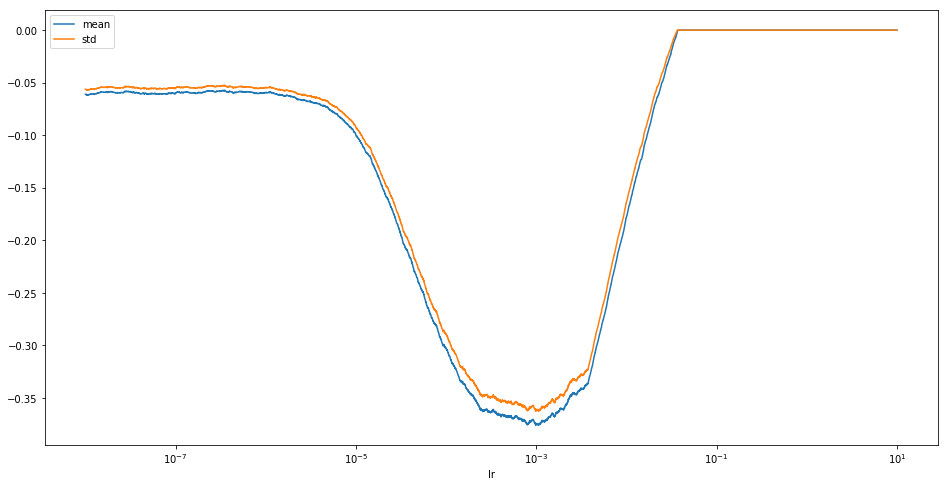

In [23]:
_[1].plot()

In [15]:
FOLDS = 10

def train_oof(train_set, test_set, units=16):
    x_train, y_train = train_set
    x_test = test_set

    y_oof = pd.DataFrame(0, index=y_train.index, columns=COORDINATES)
    y_pred = pd.DataFrame(0, index=x_test.index.unique(), columns=COORDINATES)
    scores = []
    folds = model_selection.KFold(n_splits=FOLDS, shuffle=True)
    
    for n, (index_train, index_valid) in enumerate(folds.split(y_train), 1):
        print(f"\nFold - {n} / {FOLDS}")
        
        ids_train = y_train.index[index_train]
        ids_valid = y_train.index[index_valid]
        
        data_train = (x_train.loc[ids_train], y_train.loc[ids_train])
        data_val = (x_train.loc[ids_valid], y_train.loc[ids_valid])
        
        rez, cycle, model = train_model(data_train, data_val, units)
        
        cycle.plot()
        pd.DataFrame(rez.history)[["loss", "val_loss"]].plot(figsize=(16, 8))
        scores.append(min(rez.history["val_loss"]))
        
        feat = yield_batch_test(data_val[0])
        df = model.predict_generator(feat, steps=len(data_val[0].index.unique()))
        df = scaler.inverse_transform(df)
        y_oof.loc[ids_valid] = df
        
        feat = yield_batch_test(x_test)
        df = model.predict_generator(feat, steps=len(x_test.index.unique()))
        df = scaler.inverse_transform(df)
        y_pred += df / FOLDS

    print(f"IOU на кроссвалидации: " + str(-np.round(sorted(scores), 5)))
    print(f"IOU среднее: {-np.mean(scores):0.5f} +/- {2 * np.std(scores) / len(scores) ** 2:0.5f}")

    subdir = time.strftime('%Y-%m-%d_%H-%M')
    path = pathlib.Path(f"../processed/{subdir}")
    path.mkdir(exist_ok=True)
    y_oof.to_csv(path / f"oof-{-np.mean(scores):0.5f}.csv", header=False)
    y_pred.to_csv(path / f"sub-{-np.mean(scores):0.5f}.csv", header=False)


Fold - 1 / 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, 4)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 64)          832       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 64)          12352     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 64)          12352     
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 64)          12352     
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 64)          12352     
_________________________________________________________________
conv1d_6 (Conv1D)            (None, None, 64)          12352 

/Users/WLMike/Documents/PycharmProjects/ML_venv/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in double_scalars


1000/1000 [==============================] - 9s 9ms/step - loss: -0.2881 - val_loss: -0.3246

Epoch 00001: val_loss improved from inf to -0.32463, saving model to ../processed/model.h5
Learning rate: 9.9e-04
Speed per epoch: -0.1586
Wait to stop: 3

Epoch 2/100
1000/1000 [==============================] - 8s 8ms/step - loss: -0.3619 - val_loss: -0.4228

Epoch 00002: val_loss improved from -0.32463 to -0.42281, saving model to ../processed/model.h5
Learning rate: 9.9e-04
Speed per epoch: -0.0623
Wait to stop: 3

Epoch 3/100
1000/1000 [==============================] - 8s 8ms/step - loss: -0.3952 - val_loss: -0.3868

Epoch 00003: val_loss did not improve from -0.42281
Learning rate: 9.9e-04
Speed per epoch: -0.0482
Wait to stop: 3

Epoch 4/100
1000/1000 [==============================] - 8s 8ms/step - loss: -0.4083 - val_loss: -0.4768

Epoch 00004: val_loss improved from -0.42281 to -0.47682, saving model to ../processed/model.h5
Learning rate: 9.9e-04
Speed per epoch: -0.0211
Wait to st

1000/1000 [==============================] - 8s 8ms/step - loss: -0.5673 - val_loss: -0.5353

Epoch 00035: val_loss improved from -0.53263 to -0.53526, saving model to ../processed/model.h5
Learning rate: 4.4e-05
Speed per epoch: -0.0012
Wait to stop: 3

Epoch 36/100
1000/1000 [==============================] - 8s 8ms/step - loss: -0.5802 - val_loss: -0.5301

Epoch 00036: val_loss did not improve from -0.53526
Learning rate: 4.4e-05
Speed per epoch: -0.0060
Wait to stop: 3

Epoch 37/100
1000/1000 [==============================] - 8s 8ms/step - loss: -0.5791 - val_loss: -0.5369

Epoch 00037: val_loss improved from -0.53526 to -0.53694, saving model to ../processed/model.h5
Learning rate: 4.4e-05
Speed per epoch: -0.0023
Wait to stop: 3

Epoch 38/100
1000/1000 [==============================] - 8s 8ms/step - loss: -0.5840 - val_loss: -0.5331

Epoch 00038: val_loss did not improve from -0.53694
Learning rate: 4.4e-05
Speed per epoch: -0.0049
Wait to stop: 3

Epoch 39/100
1000/1000 [=====

/Users/WLMike/Documents/PycharmProjects/ML_venv/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in double_scalars


1000/1000 [==============================] - 7s 7ms/step - loss: -0.3050 - val_loss: -0.2270

Epoch 00001: val_loss improved from inf to -0.22696, saving model to ../processed/model.h5
Learning rate: 9.9e-04
Speed per epoch: -0.1162
Wait to stop: 3

Epoch 2/100
1000/1000 [==============================] - 7s 7ms/step - loss: -0.3229 - val_loss: -0.3745

Epoch 00002: val_loss improved from -0.22696 to -0.37454, saving model to ../processed/model.h5
Learning rate: 9.9e-04
Speed per epoch: -0.0076
Wait to stop: 3

Epoch 3/100
1000/1000 [==============================] - 7s 7ms/step - loss: -0.3819 - val_loss: -0.4696

Epoch 00003: val_loss improved from -0.37454 to -0.46956, saving model to ../processed/model.h5
Learning rate: 9.9e-04
Speed per epoch: -0.0473
Wait to stop: 3

Epoch 4/100
1000/1000 [==============================] - 7s 7ms/step - loss: -0.4054 - val_loss: -0.3261

Epoch 00004: val_loss did not improve from -0.46956
Learning rate: 9.9e-04
Speed per epoch: -0.0304
Wait to st


Epoch 00035: val_loss did not improve from -0.57170
Learning rate: 9.9e-05
Speed per epoch: -0.0071
Wait to stop: 3

Epoch 36/100
1000/1000 [==============================] - 7s 7ms/step - loss: -0.5797 - val_loss: -0.5686

Epoch 00036: val_loss did not improve from -0.57170
Learning rate: 9.9e-05
Speed per epoch: -0.0058
Wait to stop: 3

Epoch 37/100
1000/1000 [==============================] - 7s 7ms/step - loss: -0.5692 - val_loss: -0.5703

Epoch 00037: val_loss did not improve from -0.57170
Learning rate: 8.7e-05
Speed per epoch: -0.0000
Wait to stop: 3

Epoch 38/100
1000/1000 [==============================] - 7s 7ms/step - loss: -0.5715 - val_loss: -0.5669

Epoch 00038: val_loss did not improve from -0.57170
Learning rate: 5.0e-05
Speed per epoch: -0.0030
Wait to stop: 3

Epoch 39/100
1000/1000 [==============================] - 7s 7ms/step - loss: -0.5771 - val_loss: -0.5765

Epoch 00039: val_loss improved from -0.57170 to -0.57645, saving model to ../processed/model.h5
Learnin

/Users/WLMike/Documents/PycharmProjects/ML_venv/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in double_scalars


1000/1000 [==============================] - 8s 8ms/step - loss: -0.2910 - val_loss: -0.2984

Epoch 00001: val_loss improved from inf to -0.29839, saving model to ../processed/model.h5
Learning rate: 9.9e-04
Speed per epoch: -0.1308
Wait to stop: 3

Epoch 2/100
1000/1000 [==============================] - 7s 7ms/step - loss: -0.3567 - val_loss: -0.4366

Epoch 00002: val_loss improved from -0.29839 to -0.43664, saving model to ../processed/model.h5
Learning rate: 9.9e-04
Speed per epoch: -0.0725
Wait to stop: 3

Epoch 3/100
1000/1000 [==============================] - 7s 7ms/step - loss: -0.3795 - val_loss: -0.4259

Epoch 00003: val_loss did not improve from -0.43664
Learning rate: 9.9e-04
Speed per epoch: -0.0339
Wait to stop: 3

Epoch 4/100
1000/1000 [==============================] - 7s 7ms/step - loss: -0.4085 - val_loss: -0.3288

Epoch 00004: val_loss did not improve from -0.43664
Learning rate: 9.9e-04
Speed per epoch: -0.0280
Wait to stop: 3

Epoch 5/100
1000/1000 [==============

1000/1000 [==============================] - 7s 7ms/step - loss: -0.5841 - val_loss: -0.5590

Epoch 00036: val_loss did not improve from -0.56598
Learning rate: 6.1e-05
Speed per epoch: -0.0081
Wait to stop: 3

Epoch 37/100
1000/1000 [==============================] - 7s 7ms/step - loss: -0.5781 - val_loss: -0.5642

Epoch 00037: val_loss did not improve from -0.56598
Learning rate: 6.1e-05
Speed per epoch: -0.0032
Wait to stop: 3

Epoch 38/100
1000/1000 [==============================] - 7s 7ms/step - loss: -0.5791 - val_loss: -0.5643

Epoch 00038: val_loss did not improve from -0.56598
Learning rate: 5.4e-05
Speed per epoch: -0.0039
Wait to stop: 2

Epoch 39/100
1000/1000 [==============================] - 7s 7ms/step - loss: -0.5842 - val_loss: -0.5672

Epoch 00039: val_loss improved from -0.56598 to -0.56722, saving model to ../processed/model.h5
Learning rate: 5.3e-05
Speed per epoch: -0.0030
Wait to stop: 3

Epoch 40/100
1000/1000 [==============================] - 7s 7ms/step - l

/Users/WLMike/Documents/PycharmProjects/ML_venv/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in double_scalars


1000/1000 [==============================] - 8s 8ms/step - loss: -0.2988 - val_loss: -0.2812

Epoch 00001: val_loss improved from inf to -0.28124, saving model to ../processed/model.h5
Learning rate: 9.9e-04
Speed per epoch: -0.1715
Wait to stop: 3

Epoch 2/100
1000/1000 [==============================] - 7s 7ms/step - loss: -0.3647 - val_loss: -0.3763

Epoch 00002: val_loss improved from -0.28124 to -0.37628, saving model to ../processed/model.h5
Learning rate: 9.9e-04
Speed per epoch: -0.0755
Wait to stop: 3

Epoch 3/100
1000/1000 [==============================] - 7s 7ms/step - loss: -0.4008 - val_loss: -0.3554

Epoch 00003: val_loss did not improve from -0.37628
Learning rate: 9.9e-04
Speed per epoch: -0.0404
Wait to stop: 3

Epoch 4/100
1000/1000 [==============================] - 7s 7ms/step - loss: -0.4058 - val_loss: -0.3966

Epoch 00004: val_loss improved from -0.37628 to -0.39663, saving model to ../processed/model.h5
Learning rate: 9.9e-04
Speed per epoch: -0.0253
Wait to st

1000/1000 [==============================] - 7s 7ms/step - loss: -0.5933 - val_loss: -0.5073

Epoch 00035: val_loss did not improve from -0.51176
Learning rate: 1.1e-05
Speed per epoch: -0.0071
Wait to stop: 3

Epoch 36/100
1000/1000 [==============================] - 7s 7ms/step - loss: -0.5906 - val_loss: -0.5057

Epoch 00036: val_loss did not improve from -0.51176
Learning rate: 1.1e-05
Speed per epoch: -0.0010
Wait to stop: 3

Epoch 37/100
1000/1000 [==============================] - 7s 7ms/step - loss: -0.5884 - val_loss: -0.5081

Epoch 00037: val_loss did not improve from -0.51176
Learning rate: 7.4e-06
Speed per epoch: -0.0009
Wait to stop: 3

Epoch 38/100
1000/1000 [==============================] - 7s 7ms/step - loss: -0.5854 - val_loss: -0.5068

Epoch 00038: val_loss did not improve from -0.51176
Learning rate: 3.8e-06
Speed per epoch: -0.0012
Wait to stop: 3

Epoch 39/100
1000/1000 [==============================] - 7s 7ms/step - loss: -0.5913 - val_loss: -0.5056

Epoch 0003

/Users/WLMike/Documents/PycharmProjects/ML_venv/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in double_scalars


1000/1000 [==============================] - 8s 8ms/step - loss: -0.2878 - val_loss: -0.3284

Epoch 00001: val_loss improved from inf to -0.32837, saving model to ../processed/model.h5
Learning rate: 9.9e-04
Speed per epoch: -0.1536
Wait to stop: 3

Epoch 2/100
1000/1000 [==============================] - 7s 7ms/step - loss: -0.3644 - val_loss: -0.3690

Epoch 00002: val_loss improved from -0.32837 to -0.36895, saving model to ../processed/model.h5
Learning rate: 9.9e-04
Speed per epoch: -0.0650
Wait to stop: 3

Epoch 3/100
1000/1000 [==============================] - 7s 7ms/step - loss: -0.3865 - val_loss: -0.3003

Epoch 00003: val_loss did not improve from -0.36895
Learning rate: 9.9e-04
Speed per epoch: -0.0417
Wait to stop: 3

Epoch 4/100
1000/1000 [==============================] - 7s 7ms/step - loss: -0.4011 - val_loss: -0.4225

Epoch 00004: val_loss improved from -0.36895 to -0.42250, saving model to ../processed/model.h5
Learning rate: 9.9e-04
Speed per epoch: -0.0265
Wait to st

1000/1000 [==============================] - 7s 7ms/step - loss: -0.5641 - val_loss: -0.5282

Epoch 00035: val_loss did not improve from -0.52941
Learning rate: 9.3e-05
Speed per epoch: -0.0006
Wait to stop: 3

Epoch 36/100
1000/1000 [==============================] - 7s 7ms/step - loss: -0.5682 - val_loss: -0.5388

Epoch 00036: val_loss improved from -0.52941 to -0.53883, saving model to ../processed/model.h5
Learning rate: 6.8e-05
Speed per epoch: -0.0051
Wait to stop: 3

Epoch 37/100
1000/1000 [==============================] - 7s 7ms/step - loss: -0.5743 - val_loss: -0.5310

Epoch 00037: val_loss did not improve from -0.53883
Learning rate: 6.8e-05
Speed per epoch: -0.0012
Wait to stop: 3

Epoch 38/100
1000/1000 [==============================] - 7s 7ms/step - loss: -0.5837 - val_loss: -0.5386

Epoch 00038: val_loss did not improve from -0.53883
Learning rate: 6.8e-05
Speed per epoch: -0.0065
Wait to stop: 3

Epoch 39/100
1000/1000 [==============================] - 7s 7ms/step - l

/Users/WLMike/Documents/PycharmProjects/ML_venv/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in double_scalars


1000/1000 [==============================] - 9s 9ms/step - loss: -0.2841 - val_loss: -0.3240

Epoch 00001: val_loss improved from inf to -0.32397, saving model to ../processed/model.h5
Learning rate: 9.9e-04
Speed per epoch: -0.1525
Wait to stop: 3

Epoch 2/100
1000/1000 [==============================] - 7s 7ms/step - loss: -0.3533 - val_loss: -0.3938

Epoch 00002: val_loss improved from -0.32397 to -0.39379, saving model to ../processed/model.h5
Learning rate: 9.9e-04
Speed per epoch: -0.0558
Wait to stop: 3

Epoch 3/100
1000/1000 [==============================] - 8s 8ms/step - loss: -0.3802 - val_loss: -0.3696

Epoch 00003: val_loss did not improve from -0.39379
Learning rate: 9.9e-04
Speed per epoch: -0.0326
Wait to stop: 3

Epoch 4/100
1000/1000 [==============================] - 7s 7ms/step - loss: -0.3985 - val_loss: -0.3722

Epoch 00004: val_loss did not improve from -0.39379
Learning rate: 9.9e-04
Speed per epoch: -0.0198
Wait to stop: 3

Epoch 5/100
1000/1000 [==============

1000/1000 [==============================] - 7s 7ms/step - loss: -0.5755 - val_loss: -0.5559

Epoch 00035: val_loss improved from -0.55211 to -0.55589, saving model to ../processed/model.h5
Learning rate: 1.1e-04
Speed per epoch: -0.0066
Wait to stop: 3

Epoch 36/100
1000/1000 [==============================] - 7s 7ms/step - loss: -0.5649 - val_loss: -0.5472

Epoch 00036: val_loss did not improve from -0.55589
Learning rate: 9.3e-05
Speed per epoch: -0.0006
Wait to stop: 3

Epoch 37/100
1000/1000 [==============================] - 7s 7ms/step - loss: -0.5765 - val_loss: -0.5533

Epoch 00037: val_loss did not improve from -0.55589
Learning rate: 7.4e-05
Speed per epoch: -0.0071
Wait to stop: 3

Epoch 38/100
1000/1000 [==============================] - 7s 7ms/step - loss: -0.5693 - val_loss: -0.5356

Epoch 00038: val_loss did not improve from -0.55589
Learning rate: 7.4e-05
Speed per epoch: -0.0008
Wait to stop: 3

Epoch 39/100
1000/1000 [==============================] - 7s 7ms/step - l

/Users/WLMike/Documents/PycharmProjects/ML_venv/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in double_scalars


1000/1000 [==============================] - 7s 7ms/step - loss: -0.2966 - val_loss: -0.2855

Epoch 00001: val_loss improved from inf to -0.28545, saving model to ../processed/model.h5
Learning rate: 9.9e-04
Speed per epoch: -0.0720
Wait to stop: 3

Epoch 2/100
1000/1000 [==============================] - 7s 7ms/step - loss: -0.3485 - val_loss: -0.3935

Epoch 00002: val_loss improved from -0.28545 to -0.39352, saving model to ../processed/model.h5
Learning rate: 9.9e-04
Speed per epoch: -0.0488
Wait to stop: 3

Epoch 3/100
1000/1000 [==============================] - 7s 7ms/step - loss: -0.3820 - val_loss: -0.3489

Epoch 00003: val_loss did not improve from -0.39352
Learning rate: 9.9e-04
Speed per epoch: -0.0330
Wait to stop: 3

Epoch 4/100
1000/1000 [==============================] - 7s 7ms/step - loss: -0.4189 - val_loss: -0.4653

Epoch 00004: val_loss improved from -0.39352 to -0.46530, saving model to ../processed/model.h5
Learning rate: 9.9e-04
Speed per epoch: -0.0373
Wait to st

1000/1000 [==============================] - 6s 6ms/step - loss: -0.5803 - val_loss: -0.5606

Epoch 00035: val_loss did not improve from -0.56282
Learning rate: 6.5e-05
Speed per epoch: -0.0092
Wait to stop: 3

Epoch 36/100
1000/1000 [==============================] - 7s 7ms/step - loss: -0.5803 - val_loss: -0.5634

Epoch 00036: val_loss improved from -0.56282 to -0.56341, saving model to ../processed/model.h5
Learning rate: 6.5e-05
Speed per epoch: -0.0064
Wait to stop: 3

Epoch 37/100
1000/1000 [==============================] - 7s 7ms/step - loss: -0.5784 - val_loss: -0.5640

Epoch 00037: val_loss improved from -0.56341 to -0.56404, saving model to ../processed/model.h5
Learning rate: 6.5e-05
Speed per epoch: -0.0030
Wait to stop: 3

Epoch 38/100
1000/1000 [==============================] - 6s 6ms/step - loss: -0.5857 - val_loss: -0.5560

Epoch 00038: val_loss did not improve from -0.56404
Learning rate: 6.4e-05
Speed per epoch: -0.0033
Wait to stop: 3

Epoch 39/100
1000/1000 [=====

/Users/WLMike/Documents/PycharmProjects/ML_venv/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in double_scalars


1000/1000 [==============================] - 9s 9ms/step - loss: -0.2757 - val_loss: -0.2440

Epoch 00001: val_loss improved from inf to -0.24403, saving model to ../processed/model.h5
Learning rate: 9.9e-04
Speed per epoch: -0.1447
Wait to stop: 3

Epoch 2/100
1000/1000 [==============================] - 7s 7ms/step - loss: -0.3502 - val_loss: -0.3874

Epoch 00002: val_loss improved from -0.24403 to -0.38742, saving model to ../processed/model.h5
Learning rate: 9.9e-04
Speed per epoch: -0.0750
Wait to stop: 3

Epoch 3/100
1000/1000 [==============================] - 7s 7ms/step - loss: -0.3936 - val_loss: -0.3684

Epoch 00003: val_loss did not improve from -0.38742
Learning rate: 9.9e-04
Speed per epoch: -0.0470
Wait to stop: 3

Epoch 4/100
1000/1000 [==============================] - 7s 7ms/step - loss: -0.4006 - val_loss: -0.4166

Epoch 00004: val_loss improved from -0.38742 to -0.41656, saving model to ../processed/model.h5
Learning rate: 9.9e-04
Speed per epoch: -0.0292
Wait to st

1000/1000 [==============================] - 8s 8ms/step - loss: -0.5666 - val_loss: -0.5348

Epoch 00036: val_loss did not improve from -0.54678
Learning rate: 9.0e-05
Speed per epoch: -0.0013
Wait to stop: 3

Epoch 37/100
1000/1000 [==============================] - 7s 7ms/step - loss: -0.5682 - val_loss: -0.5479

Epoch 00037: val_loss improved from -0.54678 to -0.54790, saving model to ../processed/model.h5
Learning rate: 6.2e-05
Speed per epoch: 0.0003
Wait to stop: 3

Epoch 38/100
1000/1000 [==============================] - 7s 7ms/step - loss: -0.5629 - val_loss: -0.5507

Epoch 00038: val_loss improved from -0.54790 to -0.55065, saving model to ../processed/model.h5
Learning rate: 2.5e-05
Speed per epoch: 0.0019
Wait to stop: 3

Epoch 39/100
1000/1000 [==============================] - 7s 7ms/step - loss: -0.5790 - val_loss: -0.5465

Epoch 00039: val_loss did not improve from -0.55065
Learning rate: 2.2e-05
Speed per epoch: -0.0042
Wait to stop: 3

Epoch 40/100
1000/1000 [=======

/Users/WLMike/Documents/PycharmProjects/ML_venv/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in double_scalars


1000/1000 [==============================] - 8s 8ms/step - loss: -0.2416 - val_loss: -0.2937

Epoch 00001: val_loss improved from inf to -0.29366, saving model to ../processed/model.h5
Learning rate: 9.9e-04
Speed per epoch: -0.2130
Wait to stop: 3

Epoch 2/100
1000/1000 [==============================] - 7s 7ms/step - loss: -0.3495 - val_loss: -0.3589

Epoch 00002: val_loss improved from -0.29366 to -0.35888, saving model to ../processed/model.h5
Learning rate: 9.9e-04
Speed per epoch: -0.0928
Wait to stop: 3

Epoch 3/100
1000/1000 [==============================] - 7s 7ms/step - loss: -0.3864 - val_loss: -0.4104

Epoch 00003: val_loss improved from -0.35888 to -0.41037, saving model to ../processed/model.h5
Learning rate: 9.9e-04
Speed per epoch: -0.0600
Wait to stop: 3

Epoch 4/100
1000/1000 [==============================] - 7s 7ms/step - loss: -0.4182 - val_loss: -0.3901

Epoch 00004: val_loss did not improve from -0.41037
Learning rate: 9.9e-04
Speed per epoch: -0.0386
Wait to st

1000/1000 [==============================] - 6s 6ms/step - loss: -0.5604 - val_loss: -0.5227

Epoch 00035: val_loss did not improve from -0.52787
Learning rate: 1.5e-04
Speed per epoch: -0.0023
Wait to stop: 3

Epoch 36/100
1000/1000 [==============================] - 6s 6ms/step - loss: -0.5618 - val_loss: -0.5283

Epoch 00036: val_loss improved from -0.52787 to -0.52832, saving model to ../processed/model.h5
Learning rate: 1.0e-04
Speed per epoch: -0.0040
Wait to stop: 3

Epoch 37/100
1000/1000 [==============================] - 7s 7ms/step - loss: -0.5651 - val_loss: -0.5275

Epoch 00037: val_loss did not improve from -0.52832
Learning rate: 1.0e-04
Speed per epoch: -0.0038
Wait to stop: 3

Epoch 38/100
1000/1000 [==============================] - 6s 6ms/step - loss: -0.5707 - val_loss: -0.5169

Epoch 00038: val_loss did not improve from -0.52832
Learning rate: 1.0e-04
Speed per epoch: -0.0049
Wait to stop: 3

Epoch 39/100
1000/1000 [==============================] - 7s 7ms/step - l

/Users/WLMike/Documents/PycharmProjects/ML_venv/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in double_scalars


1000/1000 [==============================] - 7s 7ms/step - loss: -0.2752 - val_loss: -0.3002

Epoch 00001: val_loss improved from inf to -0.30020, saving model to ../processed/model.h5
Learning rate: 9.9e-04
Speed per epoch: -0.1505
Wait to stop: 3

Epoch 2/100
1000/1000 [==============================] - 7s 7ms/step - loss: -0.3456 - val_loss: -0.3679

Epoch 00002: val_loss improved from -0.30020 to -0.36795, saving model to ../processed/model.h5
Learning rate: 9.9e-04
Speed per epoch: -0.0633
Wait to stop: 3

Epoch 3/100
1000/1000 [==============================] - 7s 7ms/step - loss: -0.3819 - val_loss: -0.3826

Epoch 00003: val_loss improved from -0.36795 to -0.38257, saving model to ../processed/model.h5
Learning rate: 9.9e-04
Speed per epoch: -0.0428
Wait to stop: 3

Epoch 4/100
1000/1000 [==============================] - 7s 7ms/step - loss: -0.4163 - val_loss: -0.4614

Epoch 00004: val_loss improved from -0.38257 to -0.46139, saving model to ../processed/model.h5
Learning rate:

1000/1000 [==============================] - 6s 6ms/step - loss: -0.5698 - val_loss: -0.5373

Epoch 00035: val_loss improved from -0.53487 to -0.53727, saving model to ../processed/model.h5
Learning rate: 2.0e-05
Speed per epoch: -0.0004
Wait to stop: 3

Epoch 36/100
1000/1000 [==============================] - 6s 6ms/step - loss: -0.5860 - val_loss: -0.5333

Epoch 00036: val_loss did not improve from -0.53727
Learning rate: 1.9e-05
Speed per epoch: -0.0073
Wait to stop: 3

Epoch 37/100
1000/1000 [==============================] - 7s 7ms/step - loss: -0.5752 - val_loss: -0.5349

Epoch 00037: val_loss did not improve from -0.53727
Learning rate: 1.5e-05
Speed per epoch: 0.0003
Wait to stop: 3

Epoch 38/100
1000/1000 [==============================] - 7s 7ms/step - loss: -0.5793 - val_loss: -0.5387

Epoch 00038: val_loss improved from -0.53727 to -0.53868, saving model to ../processed/model.h5
Learning rate: 1.1e-05
Speed per epoch: 0.0010
Wait to stop: 3

Epoch 39/100
1000/1000 [=======

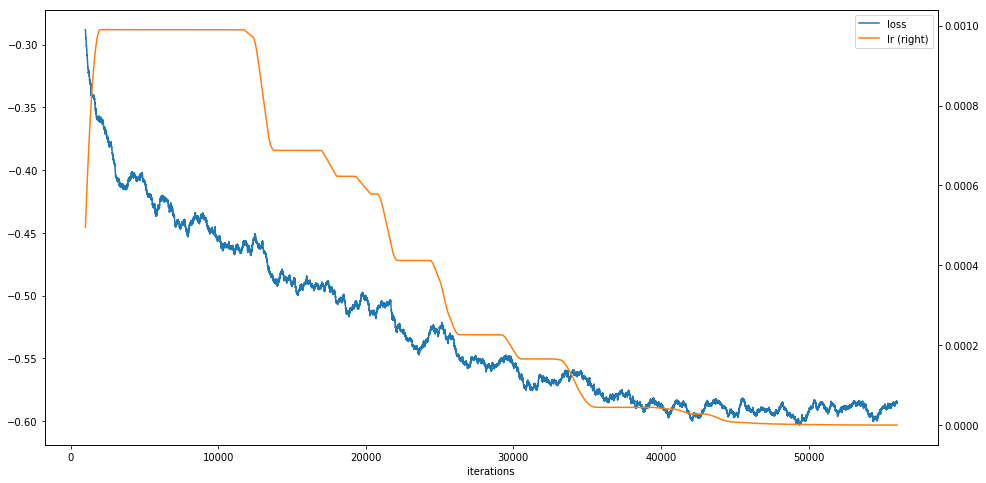

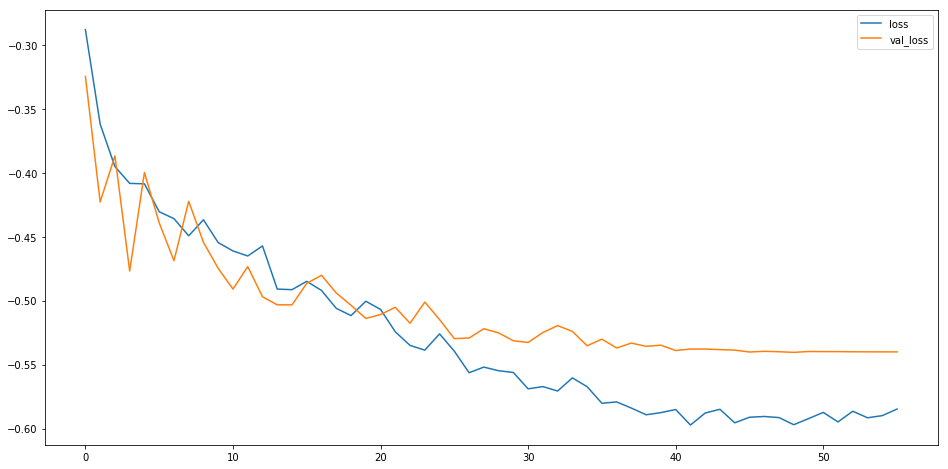

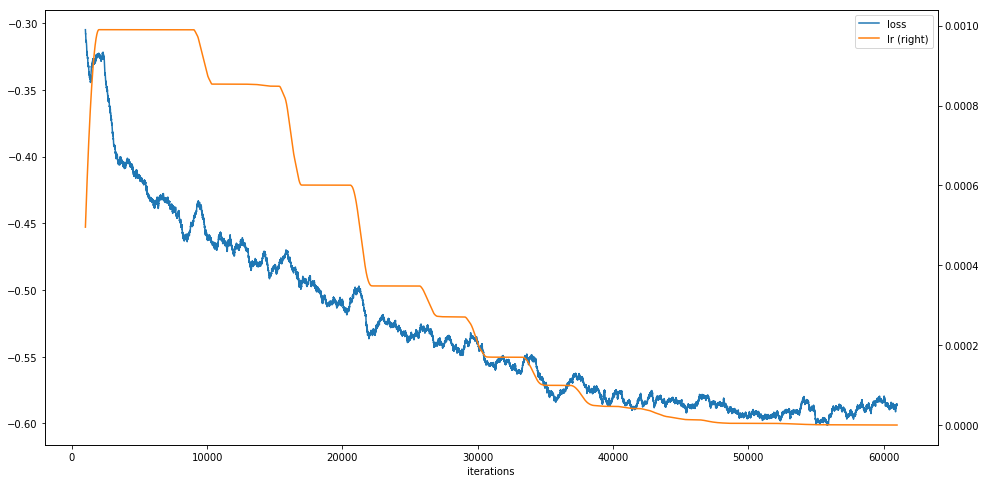

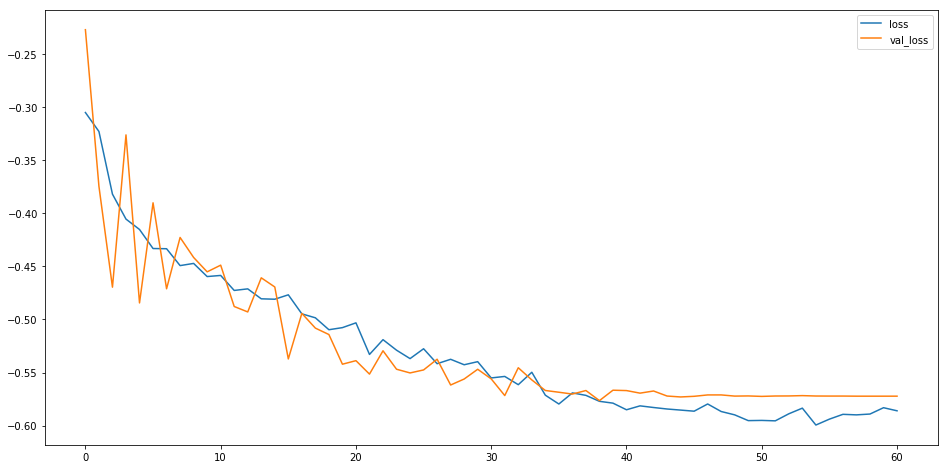

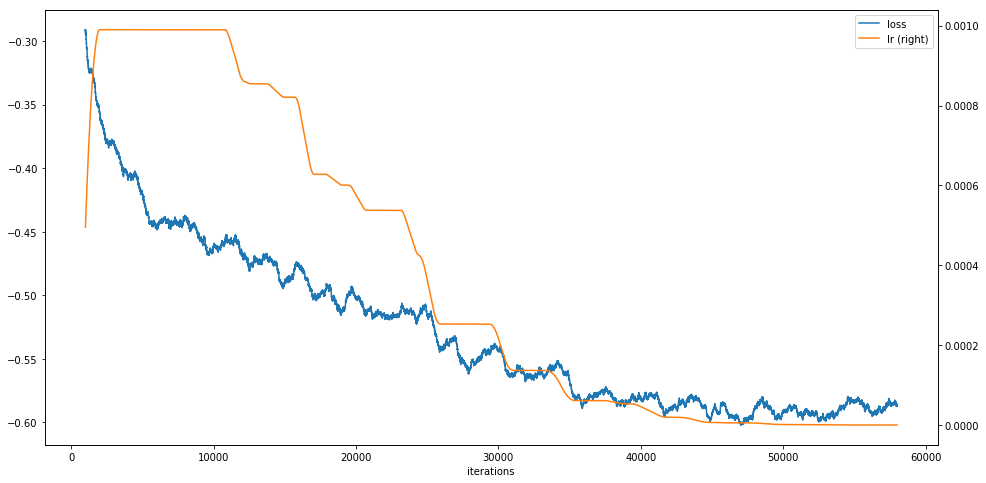

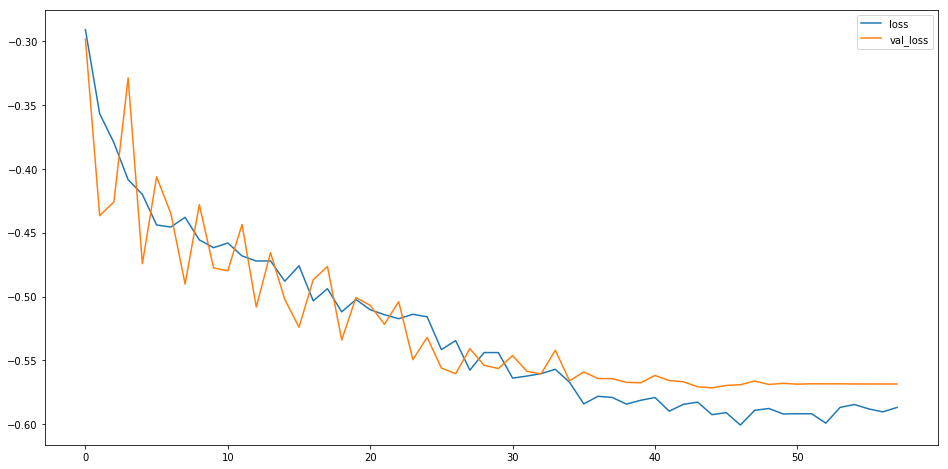

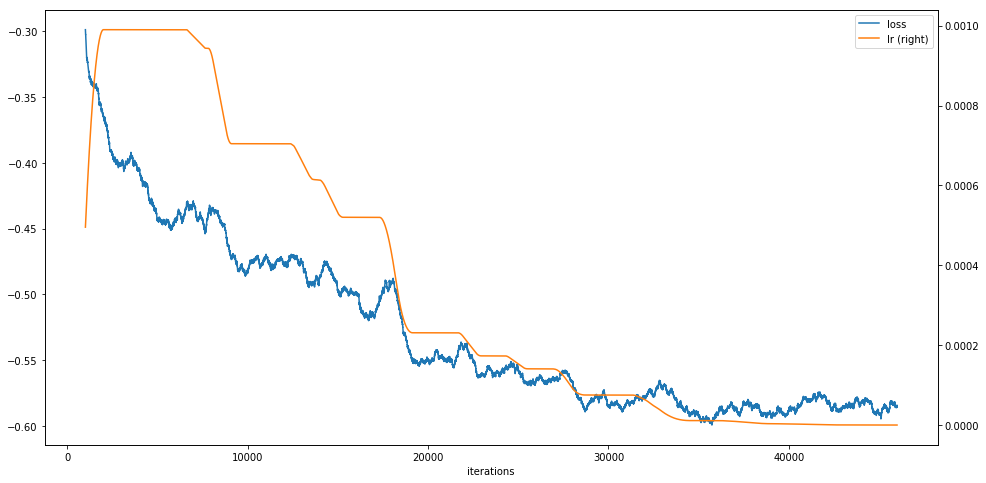

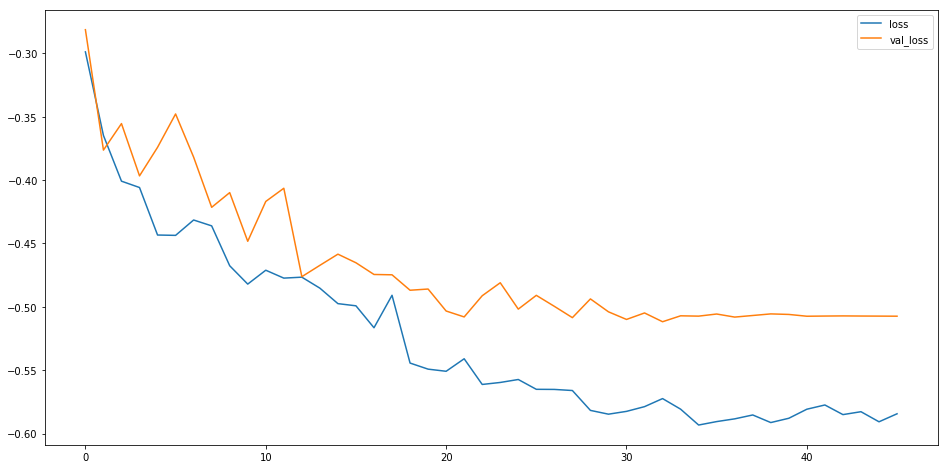

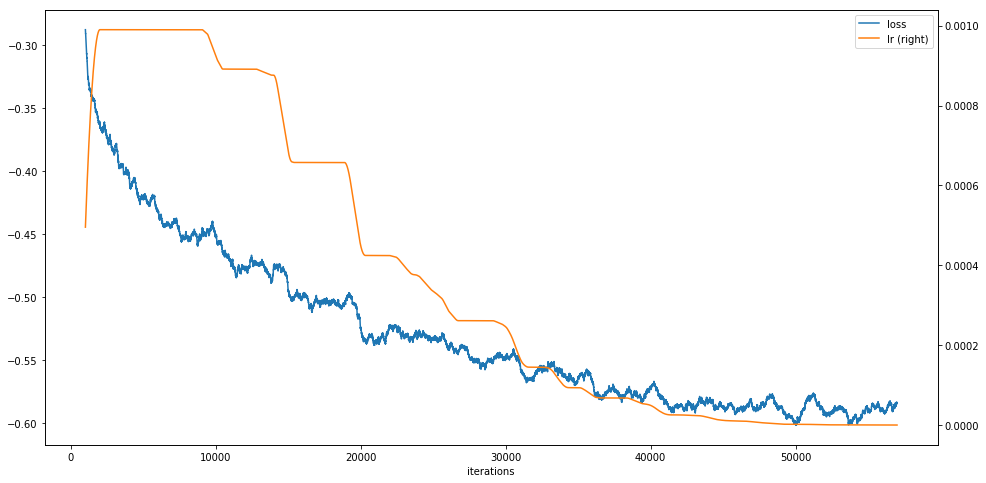

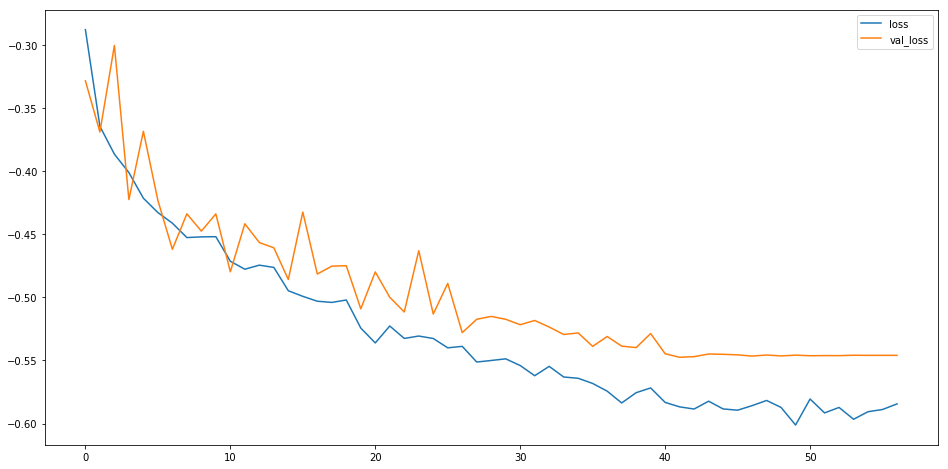

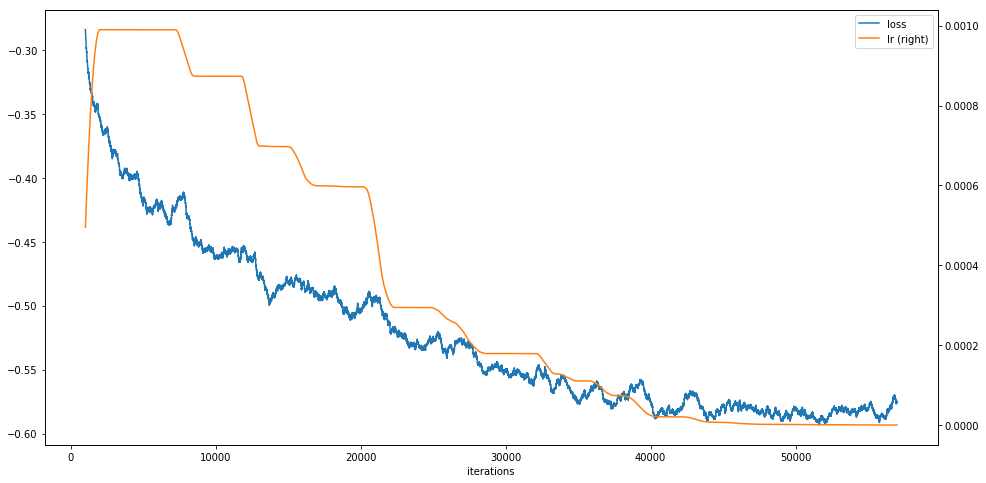

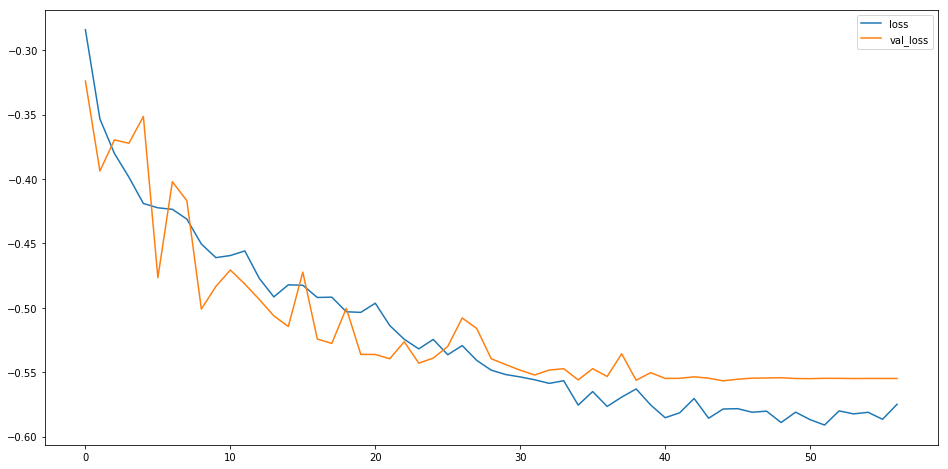

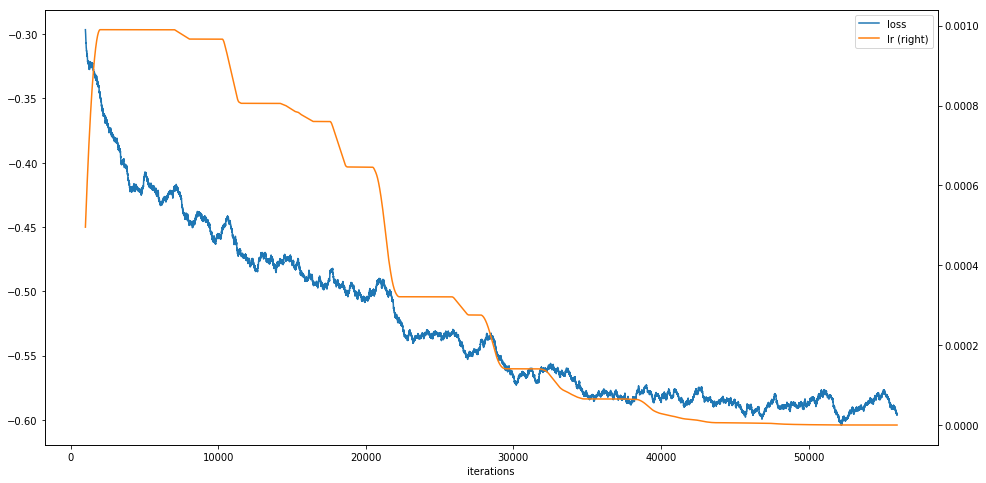

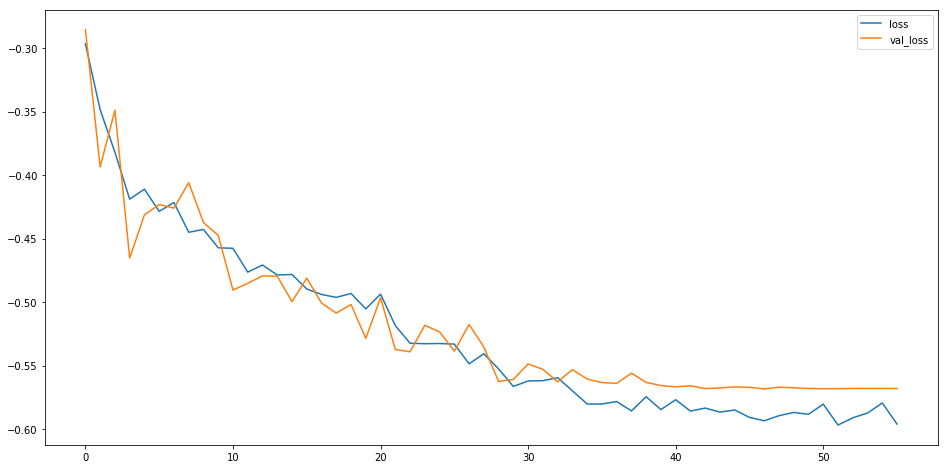

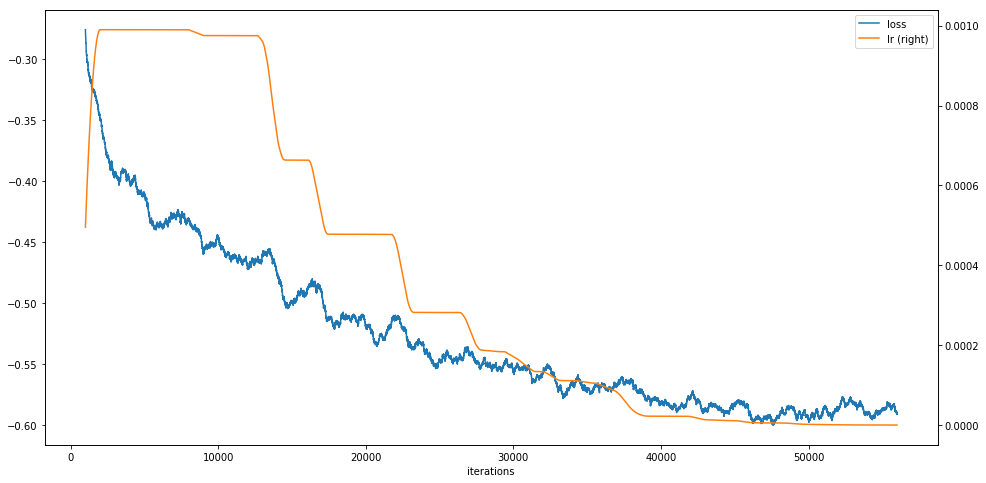

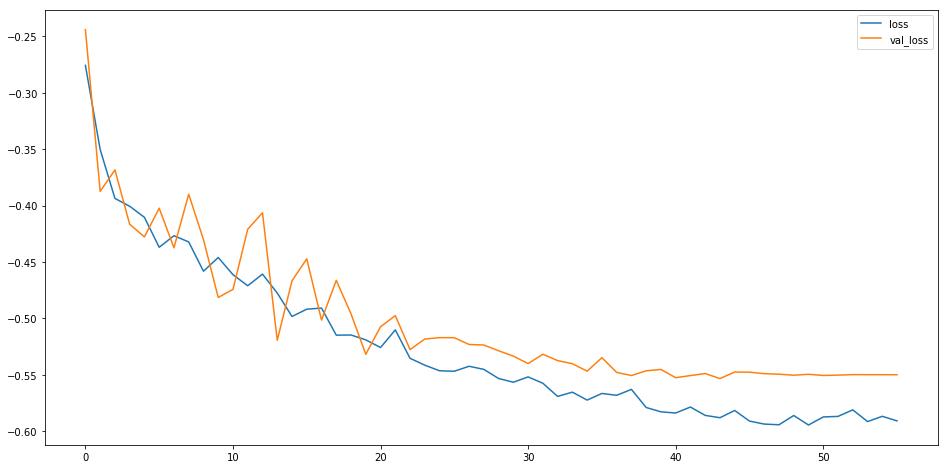

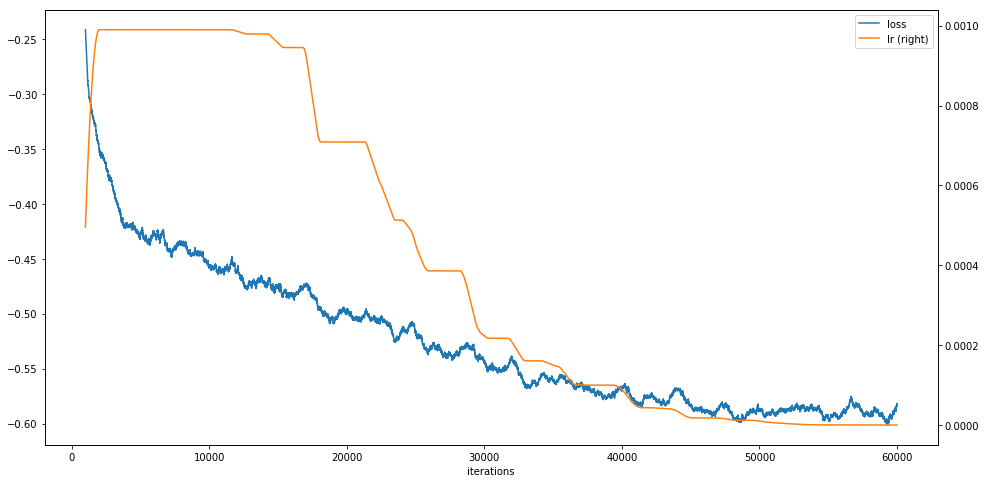

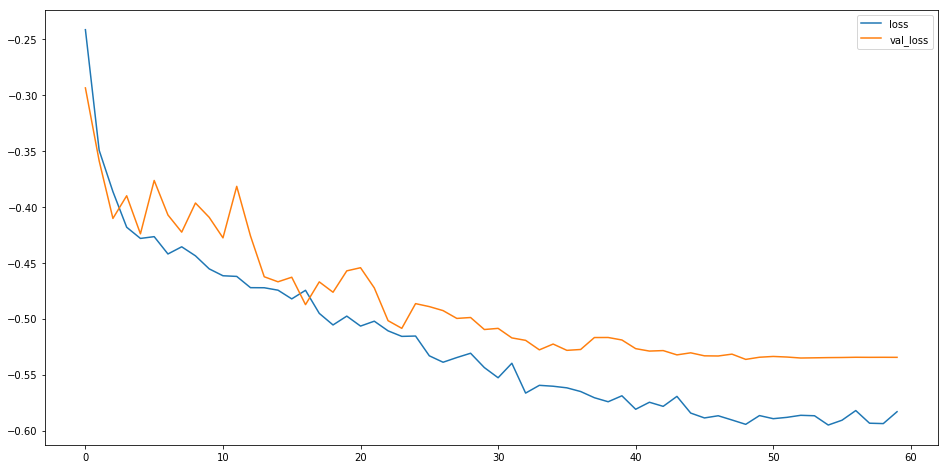

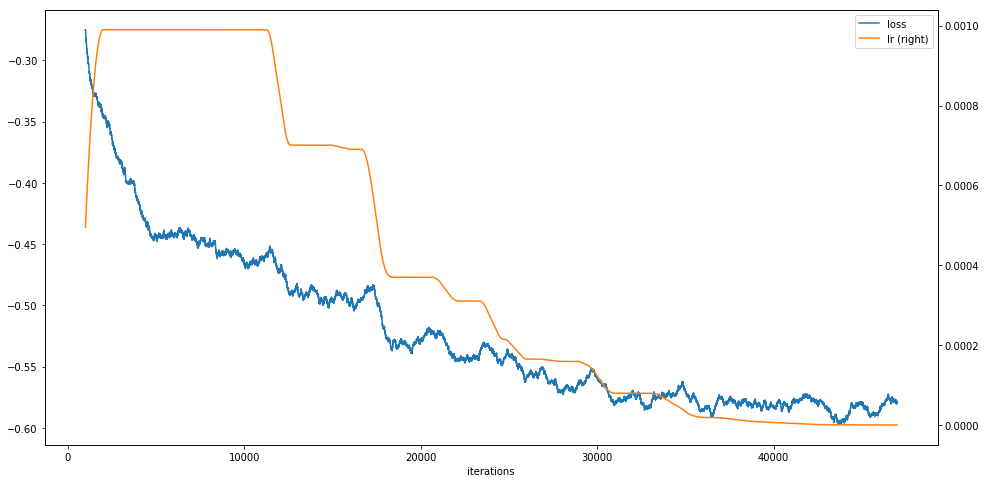

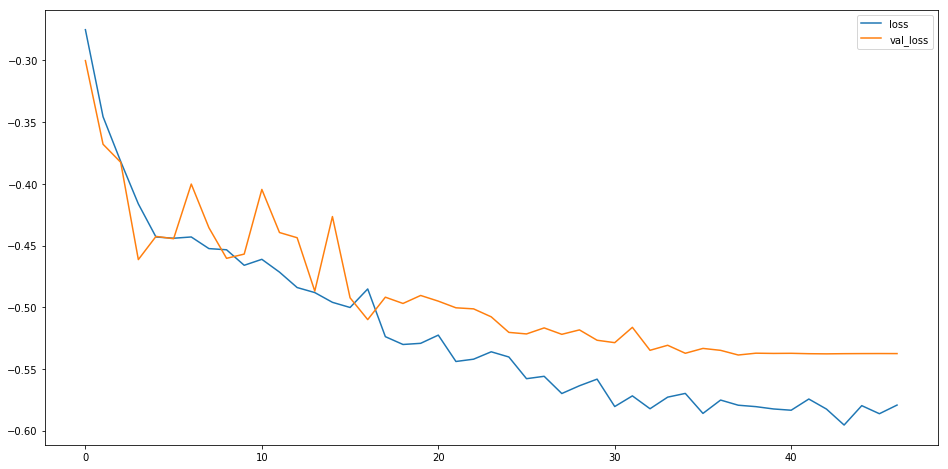

In [25]:
train_oof((votes, answers), votes_test)